Imports and loading

In [ ]:
import glob
import os
import time
import itertools
import random
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cv2
import torch
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Utils

In [ ]:

# utilities
def label_to_color(arr , palette):
    arr_3 = np.zeros((arr.shape[0] ,arr.shape[1],3) , dtype=np.uint8)
    for key , l in palette.items():
        m = arr == key
        arr_3[m] = l
    return arr_3

def color_to_label(arr_3d , palette):
    arr = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    for key , l in palette.items():
        m = np.all(arr_3d == np.array(key).reshape(1,1,3),axis=2)
        arr[m] = l
    return arr


def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def metrics(predictions, gts, label_values):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy


Unet model_and parts

In [ ]:

import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))


        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear)
        self.up2 = up(512, 128, bilinear)
        self.up3 = up(256, 64, bilinear)
        self.up4 = up(128, 64, bilinear)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x = F.log_softmax(x)
        return x


class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet2, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)

        self.P4 = double_conv(512, 512)
        self.P3 = double_conv(256, 256)
        self.P2 = double_conv(128, 128)
        self.P1 = double_conv(64, 64)

        self.up1 = up(1024, 256, bilinear)
        self.up2 = up(512, 128, bilinear)
        self.up3 = up(256, 64, bilinear)
        self.up4 = up(128, 64, bilinear)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, self.P4(x4))
        x = self.up2(x, self.P3(x3))
        x = self.up3(x, self.P2(x2))
        x = self.up4(x, self.P1(x1))
        x = self.outc(x)
        return x


Dataset_processing

In [ ]:
class ISPRS_Dataset(torch.utils.data.Dataset):
    def __init__(self , image_dir , mask_dir=None,enhance=False,factor=1, cache=True):
        super(ISPRS_Dataset, self).__init__()
        self.image_dir = image_dir
        if mask_dir is not None:
            self.mask_dir = mask_dir
        else:
            self.mask_dir = None
        _ , _ , self.image_name = next(os.walk(image_dir))
        self.enhance=enhance
        self.factor = factor
        
        self.cache = cache
        self.pixel= {0: (0, 0, 0),  # non_objects-->black
                        1: (255, 0, 0),  # building-->red
                        2: (0, 255, 255)}  # cars-->cyan
        self.pixel_inv = {v: k for k, v in self.pixel.items()}
        print(self.pixel_inv)
        if self.cache:
            self.capacity = len(self.image_name) * 1
            print('capacity:',self.capacity)
            self.image_cache = {}
            self.label_cache = {}

    def __len__(self):
        return len(self.image_name) #get length of read)images
    
    def __getitem__(self,idx):
        #idx = random.randint(0, len(self.image_name) - 1)
        if self.cache == True and (idx in self.image_cache.keys()):
            data = self.image_cache[idx]
            print('taken_image from cache',idx)
        else:
            image = cv2.imread(self.image_dir + self.image_name[idx])
            if image.shape[1] > 512:
                image=cv2.resize(image ,(512,512))
                flag=True
            data = 1 / 255 * np.array(image.transpose((2, 0, 1)),
                                        dtype='float32')
            if self.enhance==True:
                data = nn.functional.interpolate(torch.from_numpy(data), mode='linear' ,size=(512,512))
            if self.cache==True :#and idx < self.capacity:
                self.image_cache[idx] = data
        if self.mask_dir is not None:
            if self.cache==True and (idx in self.label_cache.keys()):
                label = self.label_cache[idx]
            else:
                label = cv2.imread(self.mask_dir+self.image_name[idx].replace('_RGB' , '_label'))
                if label.shape[1] > 512:
                    label = cv2.resize(label ,(512,512))
                label = np.array(color_to_label(label, palette=self.pixel_inv) , dtype = 'int64')
                if self.cache==True: #and idx < self.capacity :
                    self.label_cache[idx]= label
            return (torch.from_numpy(data), torch.from_numpy(label))
        return torch.from_numpy(data)

Train

cuda:0
(4, 4, 1, 512, 512, 3)
{(0, 0, 0): 0, (255, 0, 0): 1, (0, 255, 255): 2}
capacity: 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


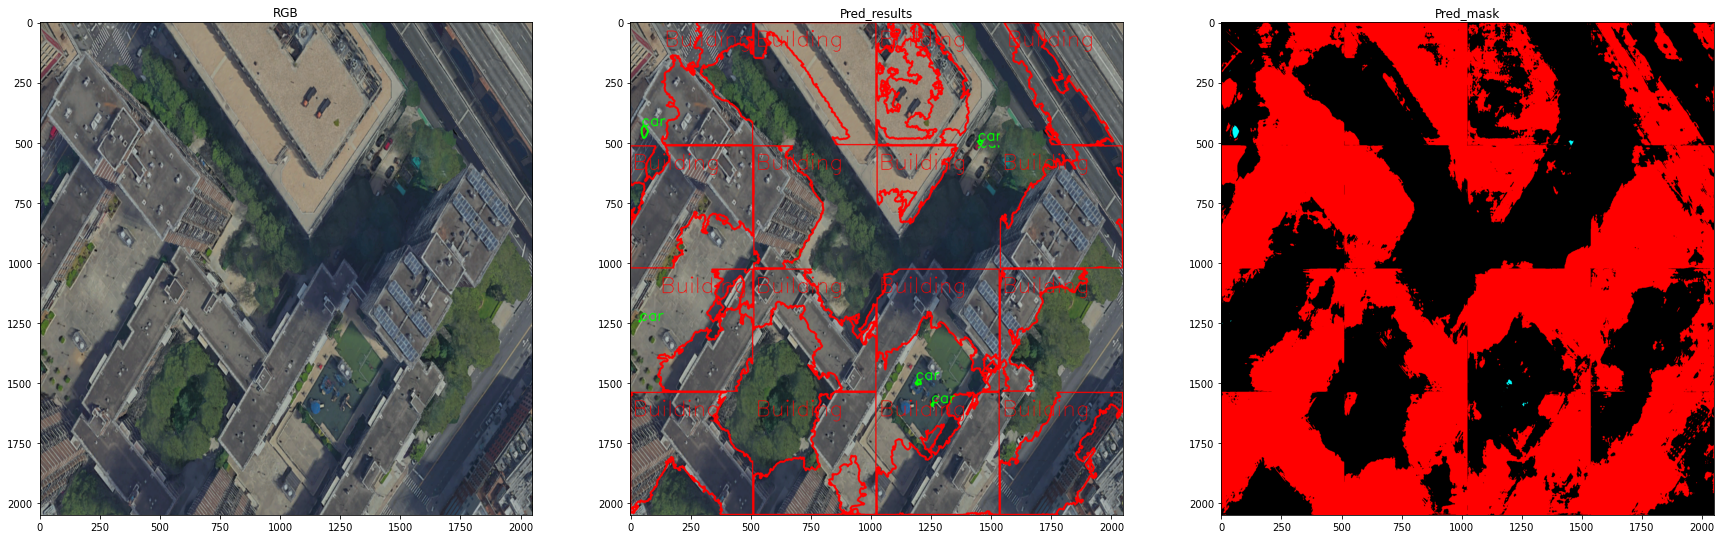

cuda:0
(4, 4, 1, 512, 512, 3)
{(0, 0, 0): 0, (255, 0, 0): 1, (0, 255, 255): 2}
capacity: 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


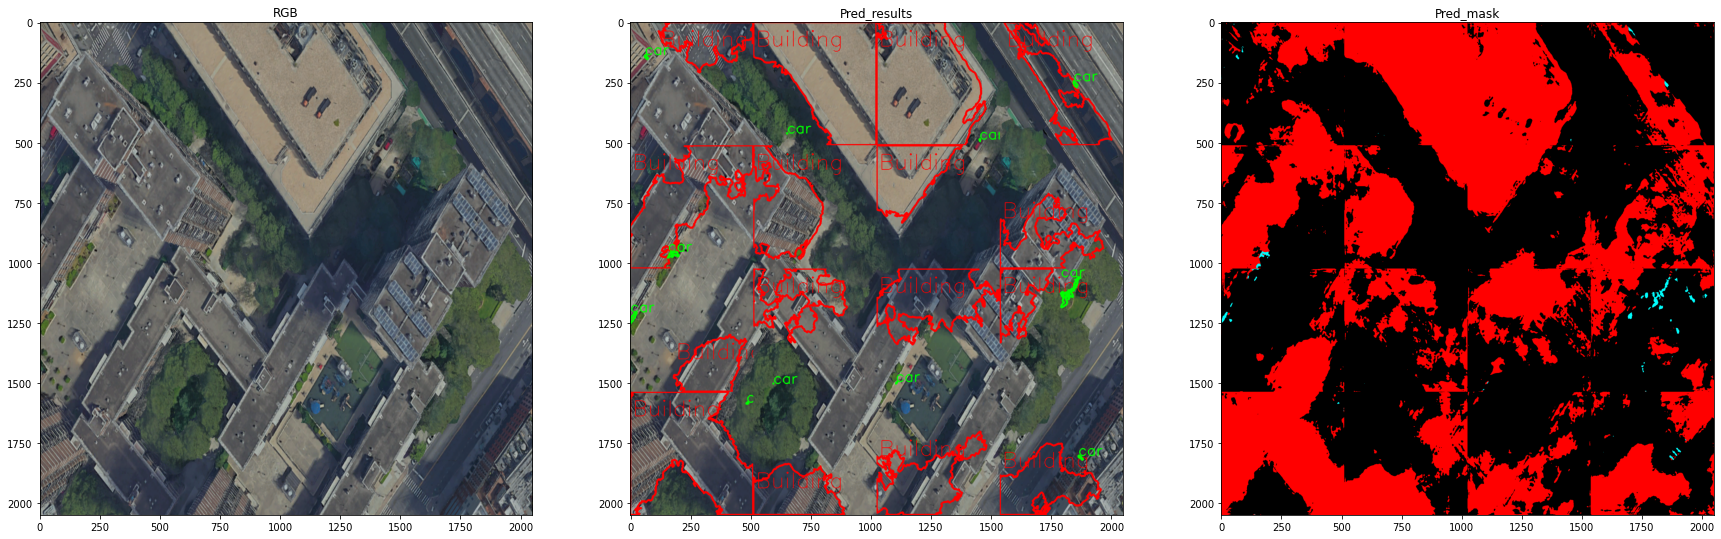

In [ ]:
warnings.filterwarnings('ignore')
from torchsummary import summary



def change_pred_values(input):
    output = input.view(input.size(0),input.size(1), -1)
    output = torch.transpose(output,1,2).contiguous()
    output = output.view(-1,output.size(2))
    #print(output.shape)
    return output


class Building_Car_Detector():
    def __init__(self , model_name,input_size , model,epoch ,ds_choice):
        super(Building_Car_Detector ,self).__init__()
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        print(self.device)
        self.cuda = True if self.device=='cuda:0' else False
        self.debug =True #False
        self.model = model.to(self.device)
        self.model_name = model_name
        self.lr = 1e-3
        self.epoch = epoch
        self.batch_size =1
        self.pixel= {0: (0,0,0),  # non_objects-->black //black
                    1: (255, 0 ,0),  # building-->red //blue
                    2: (0, 255, 255)}  # cars-->cyan //yellow
        self.pixel_inv = {v: k for k, v in self.pixel.items()}
        self.Label_names = {0:'Non_object' , 1:'Buildings' , 2:'Cars'}
        self.classes = 3
        self.input_size = input_size
        self.root_path = path+'/' #os.getcwd()+'/'
        self.ds_name = ['Sample_dataset_{}'.format(self.input_size), 'Custom_Dataset_ISPRS_{}'.format(self.input_size)]
        self.optimizer = torch.optim.Adam(model.parameters() , lr=self.lr , betas=(0.5 , 0.999))
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model_path = self.root_path+'{}_{}_{}.pth'.format(self.model_name,self.input_size,ds_choice)
        self.results =[]

    def Visualize(self, image, mask, mask_pred ,e):
        if self.debug:
            print(image.shape , mask.shape , mask_pred.shape)
        fig = plt.figure(figsize=(10, 10))
        fig.add_subplot(131)
        plt.title('RGB')
        plt.imshow(np.asarray(255 * np.transpose(image.data.cpu().numpy()[0], (1, 2, 0)), dtype='uint8'))
        fig.add_subplot(132)
        plt.title('Prediction')
        plt.imshow(label_to_color(np.argmax(mask_pred.data.cpu().numpy()[0], axis=0), palette=self.pixel))
        #if mask is not None:
        fig.add_subplot(133)
        plt.title('G_mask')
        plt.imshow(label_to_color(mask.data.cpu().numpy()[0], palette=self.pixel))
        plt.show()
        if e == self.epoch-1:
            plt.savefig(self.root_path+'Results/'+self.model_name+'_'+self.input_size+'_prediction_@{}.png'.format(e))
    
    def __del__(self):
        del self.model


    def Train(self , choice,resume=False):
        if resume== True:
            self.model.load_state_dict(torch.load(self.model_path , map_location=self.device))
        self.model.train()
        mode = 'train'
        print('Training Started....')
        image_dir = self.root_path+'{}/{}/image/'.format(self.ds_name[choice],mode)
        mask_dir = self.root_path+'{}/{}/mask/'.format(self.ds_name[choice],mode)
        trainset = ISPRS_Dataset(image_dir ,mask_dir ,cache=True)
        trainloader = torch.utils.data.DataLoader(trainset , batch_size=self.batch_size)
        print("Datset_len:{} Selected:{}".format(trainset.__len__(),self.ds_name[ds_choice]))
        #print(summary(self.model ,(3, self.input_size,self.input_size)))
        Loss = []
        for e in range(self.epoch):
            running_acc=0.0
            running_loss=0.0
            start_time = timeit.default_timer()
            for i ,(image , mask) in enumerate(trainloader):
                if self.cuda:
                    image = image.to(self.device)
                    mask = mask.to(self.device)
                self.optimizer.zero_grad()
                mask_pred = self.model(image)
                nw_loss = self.criterion(change_pred_values(mask_pred) , mask.view(-1))

                #Statistics:
                running_loss+=nw_loss.item()
                Loss.append(running_loss/trainset.__len__())

                acc=accuracy(np.argmax(mask_pred.data.cpu().numpy()[0], axis=0).flatten(),mask.data.cpu().numpy()[0].flatten())
                running_acc+=acc
                nw_loss.backward()
                self.optimizer.step()

                if i%100 == 0:
                    #running_loss=running_acc=0
                    print('epoch:{}/{} i:{} Loss: {:.4f} Acc:{}'.format(e, self.epoch , i, running_loss/trainset.__len__(), running_acc/trainset.__len__()))
                    
                    #self.Visualize(image=image , mask=mask , mask_pred=mask_pred , e=e)
            
            self.results.append('epoch:{}/{} i:{} Loss: {:.4f} Acc:{}'.format(e, self.epoch , i, running_loss/trainset.__len__(), running_acc/trainset.__len__()))        
            torch.save(self.model.state_dict() , self.model_path)
            print(self.results[-1])
            print('Training Time for epoch:{} {} min'.format(e , (timeit.default_timer()-start_time)/60.))
        plt.figure(figsize=(10,10))
        plt.xlabel('Loss')
        plt.ylabel('epoch')
        plt.title(self.model_name)
        plt.plot(Loss)
        plt.show()
        plt.savefig(self.root_path+'Results/'+self.model_name+'_'+self.input_size+'_loss.png')

    def Validation(self , choice):
        print('Model_Validation... ')
        mode = 'test'
        image_dir = self.root_path+'{}/{}/image/'.format(self.ds_name[choice],mode)
        mask_dir = self.root_path+'{}/{}/mask/'.format(self.ds_name[choice],mode)
        validset = ISPRS_Dataset(image_dir , mask_dir , cache=False)
        validloader = torch.utils.data.DataLoader(validset , batch_size = self.batch_size)
        print("Datset_len:{} Selected:{}".format(validset.__len__(),self.ds_name[ds_choice]))
        self.model.load_state_dict(torch.load(self.model_path , map_location=self.device))
        self.model.eval()
        with torch.no_grad():
            acc=0.0
            good_count=0
            for i , (image , mask) in enumerate(validloader):
                if self.cuda:
                    image = image.to(self.device)
                    mask = mask.to(self.device)
                mask_pred = self.model(image)
                running_acc=accuracy(np.argmax(mask_pred.data.cpu().numpy()[0], axis=0).flatten(),mask.data.cpu().numpy()[0].flatten())
                #print(running_acc)
                acc+=running_acc
                if running_acc >80:
                    good_count+=1
                    print(running_acc)
                    self.Visualize(image=image , mask_pred=mask_pred , mask = mask,e=1)
            print('Model:{} inp_size:{} epochs:{} accuracy:{} good_count:{} bad_count:{}' .format(self.model_name , self.input_size , self.epoch , acc/validset.__len__(),good_count , validset.__len__()-good_count))
  
    def postproc(self , pred_mask ,image):
        image = np.array(255*np.transpose(image.data.cpu().numpy()[0] ,(1,2,0)),dtype='uint8')
        pred_mask = np.array(label_to_color(np.argmax(pred_mask.data.cpu().numpy()[0] ,axis=0),palette=self.pixel),dtype=np.float32)
        
        build_mask = cv2.inRange(pred_mask, np.array([250,0,0]) , np.array([255,0,0]))
        car_mask = cv2.inRange(pred_mask ,np.array([0,250,250]) , np.array([0,255,255]) )
        cnts1 , _  = cv2.findContours(build_mask , cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        cnts , _ = cv2.findContours(car_mask , cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
        if len(cnts1)>0:
            areas = [cv2.contourArea(c) for c in cnts1]
            max_id = np.argmax(areas)
            c = cnts1[max_id]
            x,y,w,h = cv2.boundingRect(c)
            #image=cv2.rectangle(image, (x,y),(x+h , y+h),(255,0,0) , thickness=3)
            image = cv2.drawContours(image, c, -1, (255,0,0), 8)
            #image = cv2.fillConvexPoly(image, c, lineType=8, shift=0 , color =(255,255,0))
            image=cv2.putText(image , 'Building' ,(x+10,y+100),cv2.FONT_HERSHEY_SIMPLEX,3.0, (255, 0, 0) , thickness=2)
        
        if len(cnts)>0:
            c = max(cnts , key = cv2.contourArea)
            x,y,w,h = cv2.boundingRect(c)
            #image=cv2.rectangle(image , (x,y),(x+h , y+h),(0,0,255) , thickness=3)
            image=cv2.drawContours(image, c, -1, (0,255,0), 8)
            image=cv2.putText(image , 'car' ,(x,y),cv2.FONT_HERSHEY_SIMPLEX,2.0, (0, 255,0), thickness=3)

        image = image.get().astype('f') #main_line for collab should be commented if local machine is used
        #fig = plt.figure(figsize=(10, 10))
        image=np.array(image , dtype = 'uint8')
        '''fig.add_subplot(131)
        plt.title('RGB')
        plt.imshow(image)
        fig.add_subplot(132)
        plt.title('Prediction')
        plt.imshow(pred_mask)#cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()'''
        return image , pred_mask
    
    def predict(self, image_path):
        #comment below four lines if working on local machine
        !rm -r {self.root_path+'Sample_2/'}
        !mkdir {self.root_path+'Sample_2/'}
        !pip install patchify
        from patchify import patchify , unpatchify
        step = 512
        input_size_patch = 512
        enhance = False
        factor = self.input_size//input_size_patch
        large_img = cv2.cvtColor(cv2.imread(image_path,cv2.IMREAD_UNCHANGED) ,cv2.COLOR_BGR2RGB)
        large_img = cv2.resize(large_img , (2048,2048))
        patches = patchify(large_img ,(input_size_patch,input_size_patch,3) ,step = step)
        print(patches.shape)
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                cv2.imwrite(self.root_path+'Sample_2/{}_{}.png'.format(i,j) , np.array(patches[i][j][0]))
        
        if input_size_patch < 512 :
            predictset = ISPRS_Dataset(image_dir=self.root_path+'Sample_2/',enhance=enhance ,factor=factor,cache=False)
        else:
            predictset = ISPRS_Dataset(image_dir=self.root_path+'Sample_2/')
        predictloader = torch.utils.data.DataLoader(predictset)
        self.model.load_state_dict(torch.load(self.model_path , map_location=self.device))
        self.model.eval()
        results=[]
        results_mask = []
        for data in predictloader:
            pred_mask = self.model(data.to(device))
            #print(pred_mask.shape)
            out ,mask = self.postproc(pred_mask , data)
            #out = np.expand_dims(out , axis=0)
            results.append(out)
            results_mask.append(mask)

        results = np.array(results)
        results_mask = np.array(results_mask)
        large_res = np.reshape(results , (patches.shape[0],patches.shape[1],1,input_size_patch,input_size_patch,3))
        large_out = unpatchify(large_res , large_img.shape)
        large_mask = np.reshape(results_mask , (patches.shape[0],patches.shape[1],1,input_size_patch,input_size_patch,3))
        large_mask_out = unpatchify(large_mask , large_img.shape)

        fig=plt.figure(figsize= (30,30))
        fig.add_subplot(131)
        plt.title('RGB')
        plt.imshow(large_img)
        fig.add_subplot(132)
        plt.title('Pred_results')
        plt.imshow(large_out)
        fig.add_subplot(133)
        plt.title('Pred_mask')
        plt.imshow(large_mask_out)
        plt.show()
if __name__ == '__main__':
    predict=True
    n_channel =3
    n_class = 3
    ds_choice = 0 #0-> Sample_DS 1-> Full_DS
    input_size = 512 #1024
    epoch = 12
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model_dict = {'unet': UNet(n_channels=n_channel , n_classes=n_class), 
                  'unet2':UNet2(n_channels=n_channel ,n_classes=n_class)}
    if predict:
        for k , model in model_dict.items():
            detector = Building_Car_Detector(model_name=k , model=model.to(device),input_size=input_size ,epoch=1,ds_choice=ds_choice)
            sample_img = path +'/Sample_2.tif'
            detector.predict(sample_img)
        
    else:
        for k , model in model_dict.items():
            print('model_selected = ',k)
            detector = Building_Car_Detector(model_name=k , model=model , input_size=input_size,epoch=epoch,ds_choice=ds_choice)
            #detector.Train(ds_choice,resume=True)
            detector.Validation(ds_choice)